# Gioblastoma Analysis
Ferran Fontdecaba Cabero  
07 - October - 2024



## Introduction

Gioblastome is the most lethal malignant brain tumour in human adult (Ahsan et al), having a sirvavility median that ranges from 12 to 15 months after diagnosis. One of the main characteristics of this type of cancer is its heterogenicity. 

For this analysis, we decided to study a dataset of Gioblastoma (Brain cancer) extracted from Lee et al, 2024. In this study and due to the difficulty to treat this type of cancerd because of the Blood-Brain Barrier, they analise different patients and how different neuroactive drugs (antidepresants mostly) affect the treatment and survavility to the disease. The porpuse of our analysis is not to reproduce the analysis performed in the original paper but to play with the data and find things that may be interesting and try to understand hoy this type of data can be managed. To do that, we will not base our pipeline and methods on the paper itself but in our own interpretation of the data. 

This set of data is composed of 4 samples extracted from 4 different patients, refered in the original paper as "Lee et al samples". Samples were dissasociated with standard procedures and stored frozen before sequenced using 10xGenomics, NovaSeq6000 (Illumina) and CellRanger to produce the data that we used. ñslkjdfg

## Pipeline

Importing Libraries

In [1]:
import GEOparse
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import decoupler as dc
import openpyxl as ox
import sklearn as sk
from collections import Counter
import matplotlib.pyplot as plt


#### Reading Datasets

In [2]:
patient7 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/patient7", prefix="GSM6619234_GBM_P007_")
patient11 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/patient11", prefix="GSM6619235_GBM_P011_")
patient12 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/patient12", prefix="GSM6619236_GBM_P012_")
patient13 = sc.read_10x_mtx("D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/patient13", prefix="GSM6619237_GBM_P013_")

#### Merging the datasets

Once we have read oll the samples and created a anndata object with them, we will merge all this data together. It is important at this step to create a way to be able to separate the data or at least to be able to identify the origen. this is why we'll create the variable patient as follows.

In [3]:

adata = ad.concat(adatas=[patient7, patient11, patient12, patient13], merge="same",label="patient", keys=["p7", "p11", "p12", "p13"], index_unique="_")
adata.obs

,patient
AAACCCAAGTACAGAT-1_p7,p7
AAACCCATCCGATCTC-1_p7,p7
AAACCCATCTAGTACG-1_p7,p7
AAACGAAGTACCTATG-1_p7,p7
AAACGAAGTGTTTACG-1_p7,p7
...,...
TTTGGTTTCGACATAC-1_p13,p13
TTTGTTGAGAAGTCCG-1_p13,p13
TTTGTTGCAATACAGA-1_p13,p13
TTTGTTGCAGGCGAAT-1_p13,p13


#### Calculating QC metrics

The next step will be to calculate some variables so that we can asses the quality of the data. Thw normal variables to calculate are "number og genes", "number of total transcrits" and "percentage of mitocondrial transcrits". High numbers on each of this variables would suggest stressed or apoptotic behaviours and therefore we should not include them in the analysis

We decided to add the variable Malat which indicates the amount of MALAT1 present in the cell. This lncRNA is useful to determine the nuclear fraction of RNA present since it has a very strong correlation with it (CITA). We would tipically expect a 5%-40% of MALAT1 in the cell. Cells with really low percentages of MALAT1 are probably lacking a nucleous and therefore we can consider that to be empty droplets and discard them. In this case we will discard the ones that have less than 1% to be extra sure that we are not deleting relevant information.

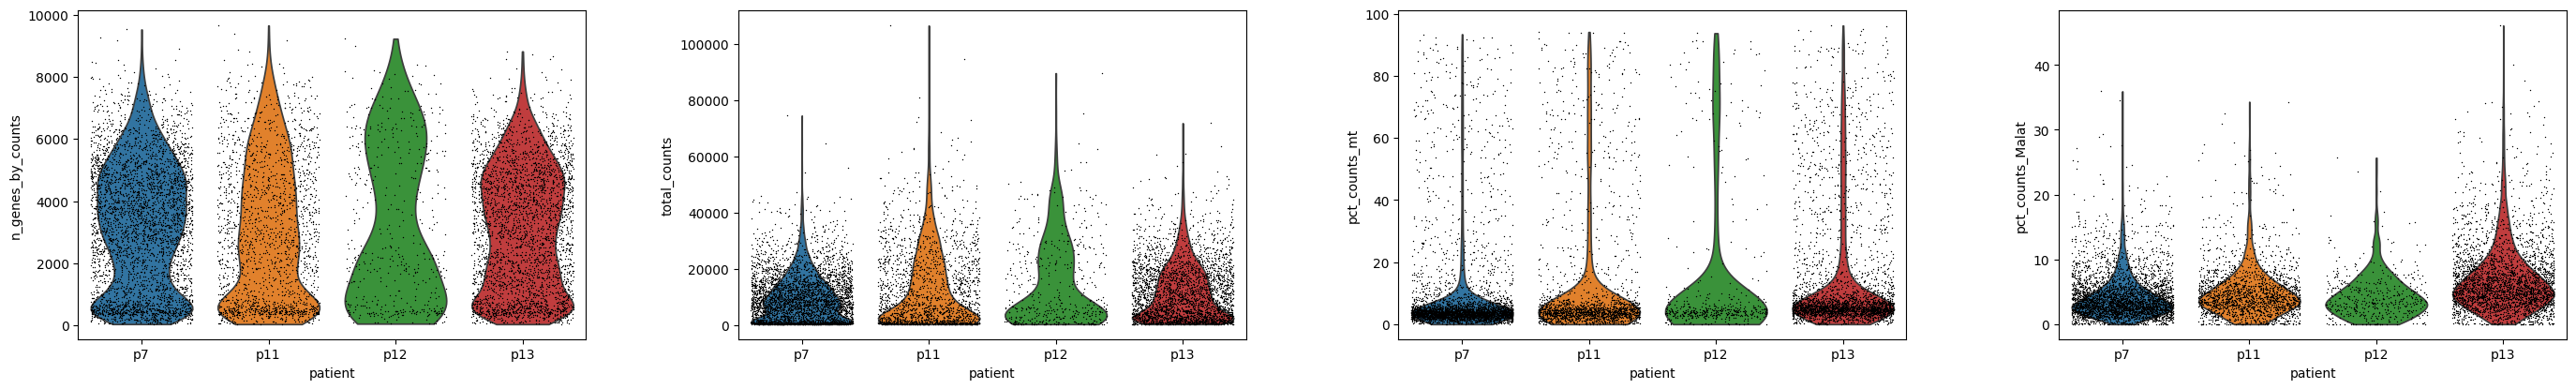

In [5]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["Malat"] = adata.var_names.str.startswith("MALAT1")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "Malat"], inplace=True, percent_top=None, log1p=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_Malat"],
    groupby="patient",
    jitter=0.4,
    multi_panel=True,
)

#### Quality control and empty droplets

A normal procedure, appart from filtering based on the quality metrics, is also to get rid of some data that is not really informative such as cells with really low counts (and probably not really a cell) and genes that are expressed in less than 3 cells (which won't add a lot of information to the analysis). This has obviously some risks. Either including cells with lower or hihger coutns will increase the reliability of your data but will reduce the amount of information present. On the other hand, excluding genes htat are not expressed in a lot of cells will reduce the probability of detecting really small populations of new celltypes but will reduce the complexity of the analysis. These are things to take into consideration when changing this thresholds.   

In [6]:
# filtering cells with less than 200 genes
sc.pp.filter_cells(adata, min_genes=200)
# filtering genes expressed in less than 3 cells
sc.pp.filter_genes(adata, min_cells=3) 
# filtering cells that have more than 13% of mithocondrial genes
adata = adata[adata.obs.pct_counts_mt < 13, :] 
# filtering cells that have less than 1% of MALAT1
adata = adata[adata.obs.pct_counts_Malat > 1, :]
adata.obs


,patient,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_Malat,log1p_total_counts_Malat,pct_counts_Malat,n_genes
AAACCCAAGTACAGAT-1_p7,p7,329,5.799093,503.0,6.222576,16.0,2.833213,3.180914,22.0,3.135494,4.373757,329
AAACCCATCCGATCTC-1_p7,p7,7566,8.931552,29088.0,10.278115,1042.0,6.949856,3.582233,340.0,5.831882,1.168867,7566
AAACCCATCTAGTACG-1_p7,p7,5362,8.587279,17782.0,9.785998,763.0,6.638568,4.290856,1072.0,6.978214,6.028568,5362
AAACGAAGTACCTATG-1_p7,p7,6098,8.715880,20138.0,9.910414,806.0,6.693324,4.002384,370.0,5.916202,1.837322,6098
AAACGAAGTGTTTACG-1_p7,p7,4302,8.367068,10262.0,9.236300,376.0,5.932245,3.664003,204.0,5.323010,1.987917,4302
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCGACATAC-1_p13,p13,4706,8.456806,20974.0,9.951087,1440.0,7.273093,6.865643,1782.0,7.486053,8.496233,4706
TTTGTTGAGAAGTCCG-1_p13,p13,5230,8.562358,19664.0,9.886596,1032.0,6.940222,5.248169,781.0,6.661855,3.971725,5230
TTTGTTGCAATACAGA-1_p13,p13,2959,7.992945,13099.0,9.480368,414.0,6.028278,3.160547,1259.0,7.138867,9.611421,2959
TTTGTTGCAGGCGAAT-1_p13,p13,2595,7.861727,10940.0,9.300273,311.0,5.743003,2.842779,450.0,6.111467,4.113346,2595


#### Doublet detection

Another thing to have into consideration is the probability of doublets, sequencing reactions with more than one cell. There are a lot of different software programs to detect this fenomenon but in this case we will use ``scrublet`` which is included in ``scanpy`` package

In [7]:
sc.pp.scrublet(adata, batch_key="patient")

#### Cell cycle

Another part that may be interesting to have a look at is the cell cycle where the cells are. This may add another layer of information to better understand why the data is behaving as it is. 

In [ ]:
s_genes = pd.read_csv("sgenes.csv")
g2m_genes = pd.read_csv("g2mgenes.csv")

sc.tl.score_genes_cell_cycle(adata, s_genes= , g2m_genes= , copy= True)

#### Cancer cells detection

Finally, before starting the preprocessing of the data and since we are working with cancer cells, we have to aknowledge the fact that not all cells in a tumour are cancer cells. This is normally acomplished in the analysis downstream having a look on the marker genes and identifying cancer genes that are overexpressed in the diferent clusters. It is a very manual step that requires some knowledge of the data that you are working with since different cancers have different marker genes. 

In this analysis we want to test a newly developed software named "Cancer Finder" (Zhong et al 2024) that is capable to identify cancer cells based on the expression matrix using a Neural Network algorithm. According to the authors, it has a ~95% of accuracy on most samples. We will compare the results of this software to the classification that teh original paper does in this regard.

In order to use it we well have to follow the instructoins on the github page https://github.com/Patchouli-M/SequencingCancerFinder/tree/master (consulted in 09/Oct/2024) 
- First, we will save our expression matrix as a .csv file as follows

In [8]:
counts = pd.DataFrame(adata.X.todense()).T
counts.columns=adata.obs.index.to_list()
counts.insert(0, column="Symbol", value=adata.var.index.to_list())
counts.to_csv("D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/Matrix.csv", header=True, index=False)


- Next, we will have to download the pretrained model from the same github page
- Finally we can run the "infer.py" program in our terminal supplying the model we download, our expression matrix and the place where the output should go. In this case I used the following code 

`C:/Users/Ferran/anaconda3/envs/py3.12.6/python.exe "d:/Datos de usuario/Desktop/Single Cell Analysis/1. Other Githubs/Cancer_finder/infer.py" `

`--ckp="d:/Datos de usuario/Desktop/Single Cell Analysis/1. Other Githubs/Cancer_finder/model_epoch92.pkl" `

`--matrix="d:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Data/Matrix.csv" `

`--out="d:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Gioblastoma (GSE214966) analysis/out.csv"`

There are options to train your own model but in this case we will use the one pretrained.

Once the program has finished, we will read the output and merge it to our metadata.

In [9]:
rescan = pd.read_csv("out.csv", names=["sample", "scf_predict"])
rescan["scf_predict"] = np.where(rescan["scf_predict"] == "1.0", 'Cancer cell', 'Normal cell')
merged = pd.merge(adata.obs, rescan, "left", left_index=True, right_on="sample")
merged.set_index("sample", inplace=True)
adata.obs = merged
adata.obs.head()

,patient,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_Malat,log1p_total_counts_Malat,pct_counts_Malat,n_genes,doublet_score,predicted_doublet,scf_predict
sample,,,,,,,,,,,,,,,
AAACCCAAGTACAGAT-1_p7,p7,329,5.799093,503.0,6.222576,16.0,2.833213,3.180914,22.0,3.135494,4.373757,329,0.071111,False,Normal cell
AAACCCATCCGATCTC-1_p7,p7,7566,8.931552,29088.0,10.278115,1042.0,6.949856,3.582233,340.0,5.831882,1.168867,7554,0.036930,False,Cancer cell
AAACCCATCTAGTACG-1_p7,p7,5362,8.587279,17782.0,9.785998,763.0,6.638568,4.290856,1072.0,6.978214,6.028568,5360,0.084918,False,Cancer cell
AAACGAAGTACCTATG-1_p7,p7,6098,8.715880,20138.0,9.910414,806.0,6.693324,4.002384,370.0,5.916202,1.837322,6093,0.030739,False,Cancer cell
AAACGAAGTGTTTACG-1_p7,p7,4302,8.367068,10262.0,9.236300,376.0,5.932245,3.664003,204.0,5.323010,1.987917,4298,0.032172,False,Cancer cell


#### Preprocessing

Now we will begin preprocessing the data so that we can do dimensionality reductions and be able to interpret it. There are a few things to take in consideration here.
- Normalizing the data stablishes 0 as the median for each gene so that you have positive and negative values for the expressions that are above and below the median expression.
- logarithmize makes the data have a normal distribution
- Identifying the most variable genes to work only with them. This will reduce the computational stress and significantly increase the speed of the analysis only losing very little information
- Either a large expression of genes or mitocondrial genes may affect the ratios of the other gene expressions in a cell. To account for that we will perform a regression to extract that bias
- finally, we can perform a dimensional reduction using Principal components analysis (PCA)
- Once the PCA is done, we will integrate the data. In this case we have used `Harmony` software to integrate the different samples together. 

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)
# high variable genes 
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
# regression out variables that may be affecting biasing our data
sc.pp.regress_out(adata, ["pct_counts_mt", "total_counts"], copy=True)
# PCA
sc.tl.pca(adata)
# integration of the different samples
sc.external.pp.harmony_integrate(adata, "patient")
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

2024-10-12 11:27:18,351 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-10-12 11:27:19,639 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-10-12 11:27:19,709 - harmonypy - INFO - Iteration 1 of 10
2024-10-12 11:27:21,615 - harmonypy - INFO - Iteration 2 of 10
2024-10-12 11:27:23,415 - harmonypy - INFO - Iteration 3 of 10
2024-10-12 11:27:25,185 - harmonypy - INFO - Iteration 4 of 10
2024-10-12 11:27:26,924 - harmonypy - INFO - Iteration 5 of 10
2024-10-12 11:27:28,267 - harmonypy - INFO - Converged after 5 iterations


#### Neighbours, UMAP and clustering

At this point, we will start to construct the clustering analysis and visualising our data

C:\Users\Ferran\AppData\Local\Temp\ipykernel_8896\1176618173.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, flavor="leidenalg", n_iterations=2) # flavour=igraph has some kind of bug


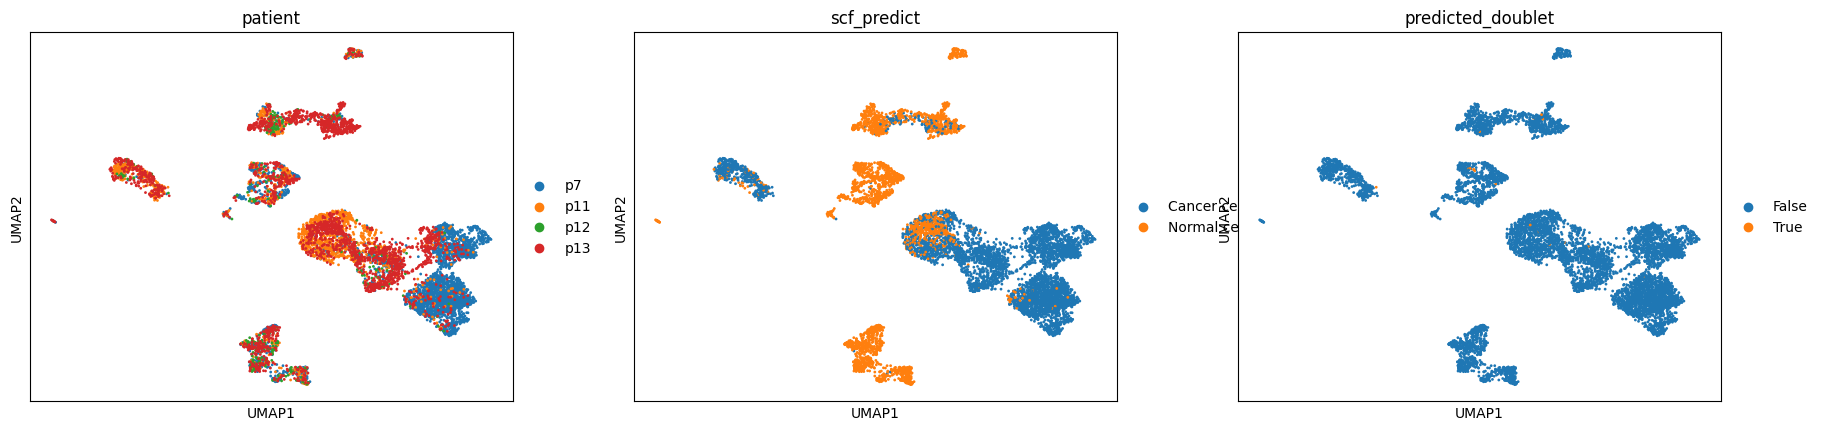

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, flavor="leidenalg", n_iterations=2) # flavour=igraph has some kind of bug
sc.pl.umap(adata, color=["patient", "scf_predict", "predicted_doublet"])

As we can see in the above result, integration of this data is quite off. There can be seen a clear separation between the two major donnors (p7 and p13) in the right clusters. Normally in this case we would search for an alternative and see if the approach of the new algorithm can solve the problem and although we tried to do that using ``Bbknn`` algorithm the results were actually worse than with ``Harmony``.

Cancer cells have a very variable expression of genes across diferent donors/cell origins and specially on gioblastoma (Lee et al 2024). This is still a little bit unclear with current science knowledge but it multiomics approaches are normally what are necessary to perform a good data integration (Cai et al 2022, Satija et al 2019). But unfortunatelly, we don't have avaliable any other omics data for this dataset and it is not in the scope of this analysis to perform a deep integration. 

As for the predicted doublets, we would normally leave them in the data unless there are clusters that are clearly formed by them, in which case you can exclude them from the downstream analysis or leave them be. In this case, we can see that there are very few and we don't have to worry to much. 

# Cluster annotation

Once all the data has been preprocessed, we can start annotating the cluster with the actual celltype per cluster. To do that we will first use the PanglaoDB to automatically annotate some of the clusters. Makeing automatic some of the traditionally manual steps make results much more reliable as we don't introduce biases in our analyses. Nowadays, there are a lot of different options to make steps automatic, as some that we have already used in this pipeline, but with annotation of clusters it makes a lot of difference since before this would be done by searching a few marker genes for each celtype instead of analysing a lot if not all the genes.

One of the best well known databases to perform this annotation with is Panglao which contains numerous genes and which organ and tissue are these described to be more present or overexpressed. The package ``decoupler`` makes use of this database, among others, to perform this annotation by running a Over Representation Analysis (ORA) to see if a set of features are over-represented in the selected features. 

In [12]:
markers = dc.get_resource('PanglaoDB')

# Filter by canonical_marker and human
markers = markers[markers['human'] & markers['canonical_marker'] & (markers['human_sensitivity'] > 0.5)]
# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
# Use only relevant organs
markers = markers[(markers["organ"] == "Brain") | (markers["organ"] == "Immune system")]
# run an overexpression analysis
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,
    use_raw=False
)
acts = dc.get_acts(adata, obsm_key='ora_estimate')

1 features of mat are empty, they will be removed.
Running ora on mat with 7510 samples and 25839 targets for 17 sources.


  0%|          | 0/7510 [00:00<?, ?it/s]

Now we can rank the different groups to label them with a celltype

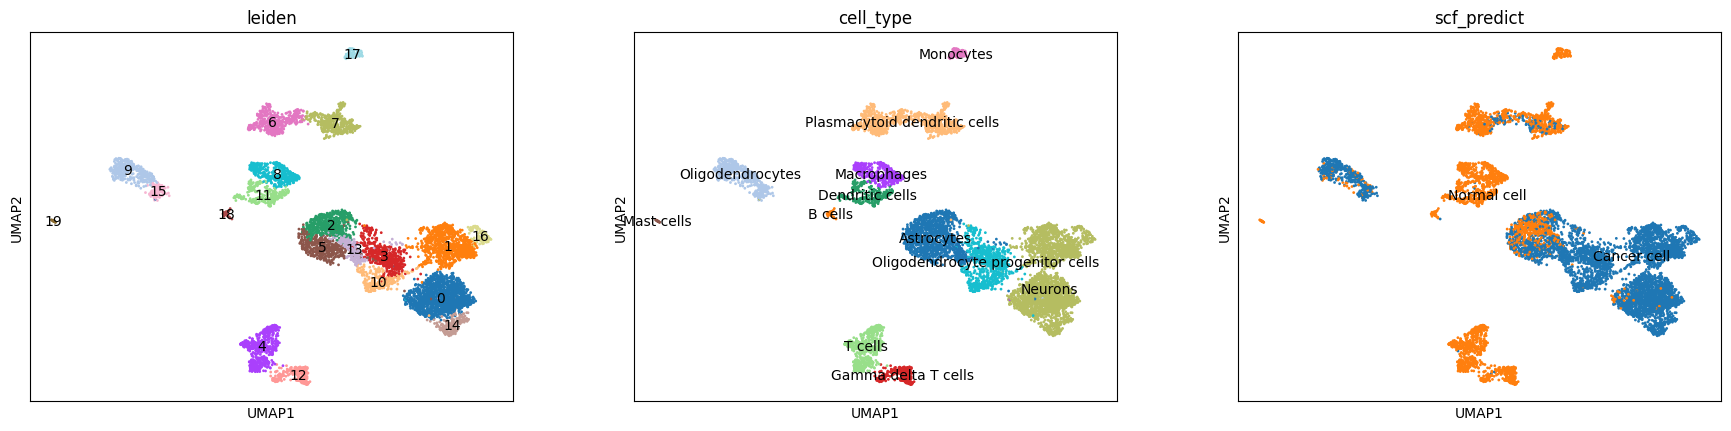

In [13]:
df = dc.rank_sources_groups(acts, groupby="leiden", reference='rest', method='t-test_overestim_var')
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]
# Visualize
sc.pl.umap(adata, 
           color= ["leiden", 'cell_type', "scf_predict"], 
           legend_loc="on data",
           legend_fontsize="medium",
           legend_fontweight="normal")

As you can see in the above graphics, some of the clusters that are together have been labelled with the same celltype (e.g. clusters 9 and 15 as Oligodendrocytes). Although that the PCA and clustering found differences in those clusters, the overall expression of those cells is the same according to our marker gene database (PanglaoDB). But what is more important about it is the information that we can see in the third UMAP: result from CancerFinder. As you can see, in blue are labeled all the cells that, according to Cancer finder, are Cancer cells. 

One interesting thing about it is that most of the Normal cells are immune cells (Gamma delta T cells, T cells, B cells, Macrophages, Monocytes) while all cancer cells are brain cells. This is because tumours are surrounded by immune cells trying to fight the tumour and get mixed with the actual tumour when the sample is extracted. Beeing able to identify which is which is crucial to perform acurate analysis. In the original paper, authors say that astrocyte (Nestin) and neuron progenitor (S100B and GFAP) cells as long as not expressing immune cells markers (CD45) is enough to identify cancer cells (Lee et al 2024). as we can see on the 2nd UMAP above, these celltypes are precisely the ones that ``decoupler`` has labelled the cancerous cells with (Neurons, Oligodendrocyte progenitor and astrocytes), apart from the oligodendrocytes to the left of the UMAP. 

This points out that Cancer finder is clearly doing a good job on detecting cancer cells according to the original authors of this paper. Even with that, there are some clusters that need some refinement or closer look to see if this annotation is good enough. To have a clear annotation of the different clusters we will annotate each cluster with the majorit cancer status in that cluster. As we can see, clusters annotated as Astrocytes may be in the middle of beeing considered cancer or not. This is where you would like to have a deeper look at the genes expressed by these clusters to manually analyse the annotation.



In [14]:
dummy_dct = {}
for clust in adata.obs["leiden"].unique().tolist():
    if Counter(adata.obs[adata.obs["leiden"] == clust]["scf_predict"]).most_common()[0][0] == "Cancer cell":
        dummy_dct[clust] = "Cancer clust"
    else:
        dummy_dct[clust] = "Normal clust"

adata.obs["clust_status"] = [dummy_dct[cell_clust] for cell_clust in adata.obs["leiden"].to_list()]


Now we'll have a look at some of the genes that the original paper uses to describe cancer cells. There are 3 "cell types" in the classification that they do:  
- Gioblastoma cells   <-  NES+ or S100B+ CD45-
- Other cells         <-  NES- or S100B- CD45-
- immune cells        <-  NES- or S100B- CD45+

They defend that this classification is able to capture the majority of malignant cells given that the gioblastoma cells overexpress most of the typical malignant cell markers such as SOX2, CD133, EGFR and Ki67. Cancer Finder, on the other hand, is using BEX3, MARCKSL1, SOX2, NOVA1, TUBB2B, CKB, PTN, GPM6B, MAP2 and UCHL1 as marker genes for gioblastoma instead of only malignancy. This gives Cancer Finder a more precise and complete look for marker genes. 

following this classification as well, CD45 is an important criteria into finding malignant cells as well. We can see a UMAP of the expression of this gene below.


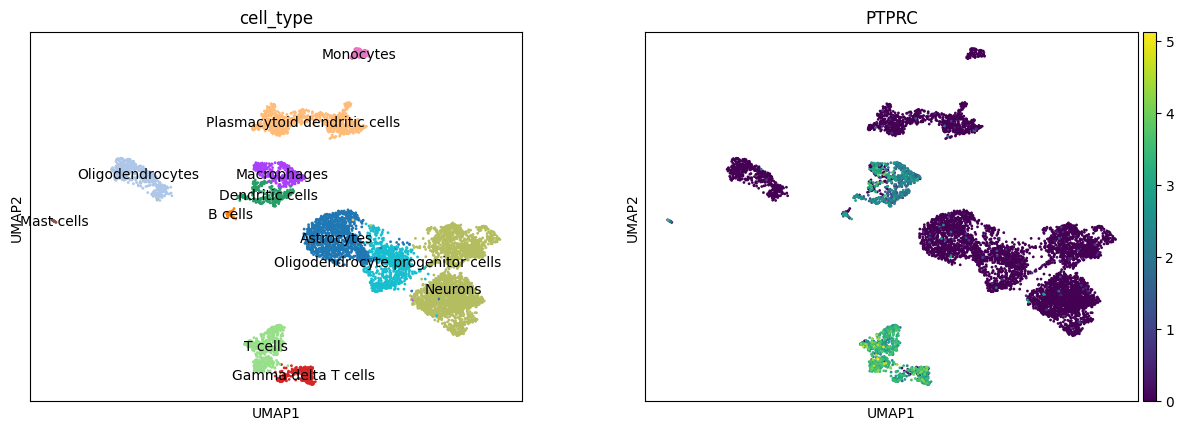

In [15]:
sc.pl.umap(adata, 
           color= ["cell_type", "PTPRC"], # EGFR, SOX2, CD133 and Ki67
           legend_loc="on data",
           legend_fontsize="medium",
           legend_fontweight="normal")

As we can se above, not all immune cells may express the CD45 gene. In fact the cluster annotated as Monocytes doesn't do it at all. A bibliografical research about this subject we can find that, as far as we know, Monocytes are a celltype from the immune system that, although they express CD45 gene in the early stages of their development, it has been described that this expression is an inhibitor of the monocyte differentiation (Deszo et al 2001) and also most of the adult monocytes does not express this gene at all (Ahmed et al 2022). This misslabelling from the authors it is probbably not causing major problems but it is worth to noticing it. 

Another celltype that stand out are the "Plasmacitoid dendritic cells". This cells alsonot expressing the CD45 gene as we can see in the UMAP above. In this case bibliographi tells us that they should (Ye et al 2020). In fact, we can check what genes are these clusters expressing so that we can have a better understanding of their behaviour. To do that we wll build UMAPS with all the genes described in Ye et al 2020 to be overexpressed and not expressed at all.

- Not expressed: CD3, CD19, CD14, CD16 and CD11c
- Overexpressed: CD303, CD304, ILT7, CD4, CD45RA, CD68, ILT3 and CD123

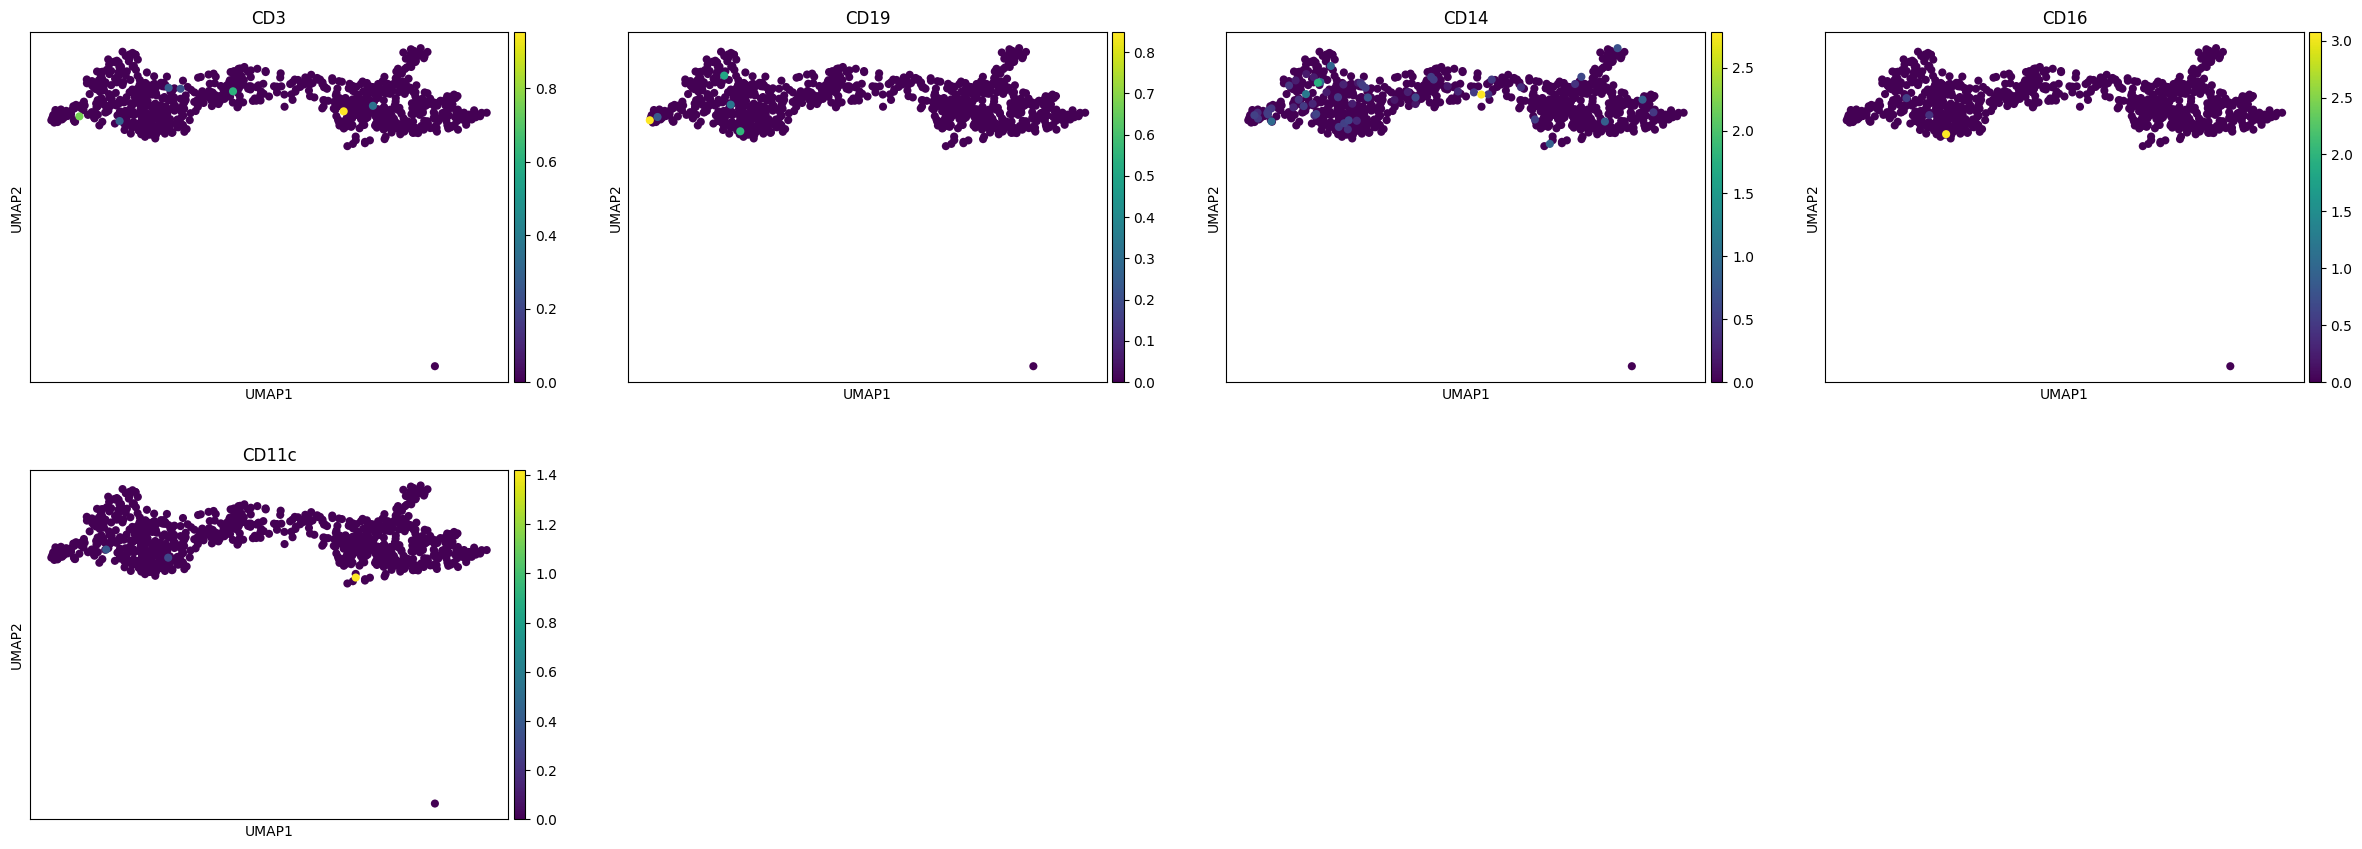

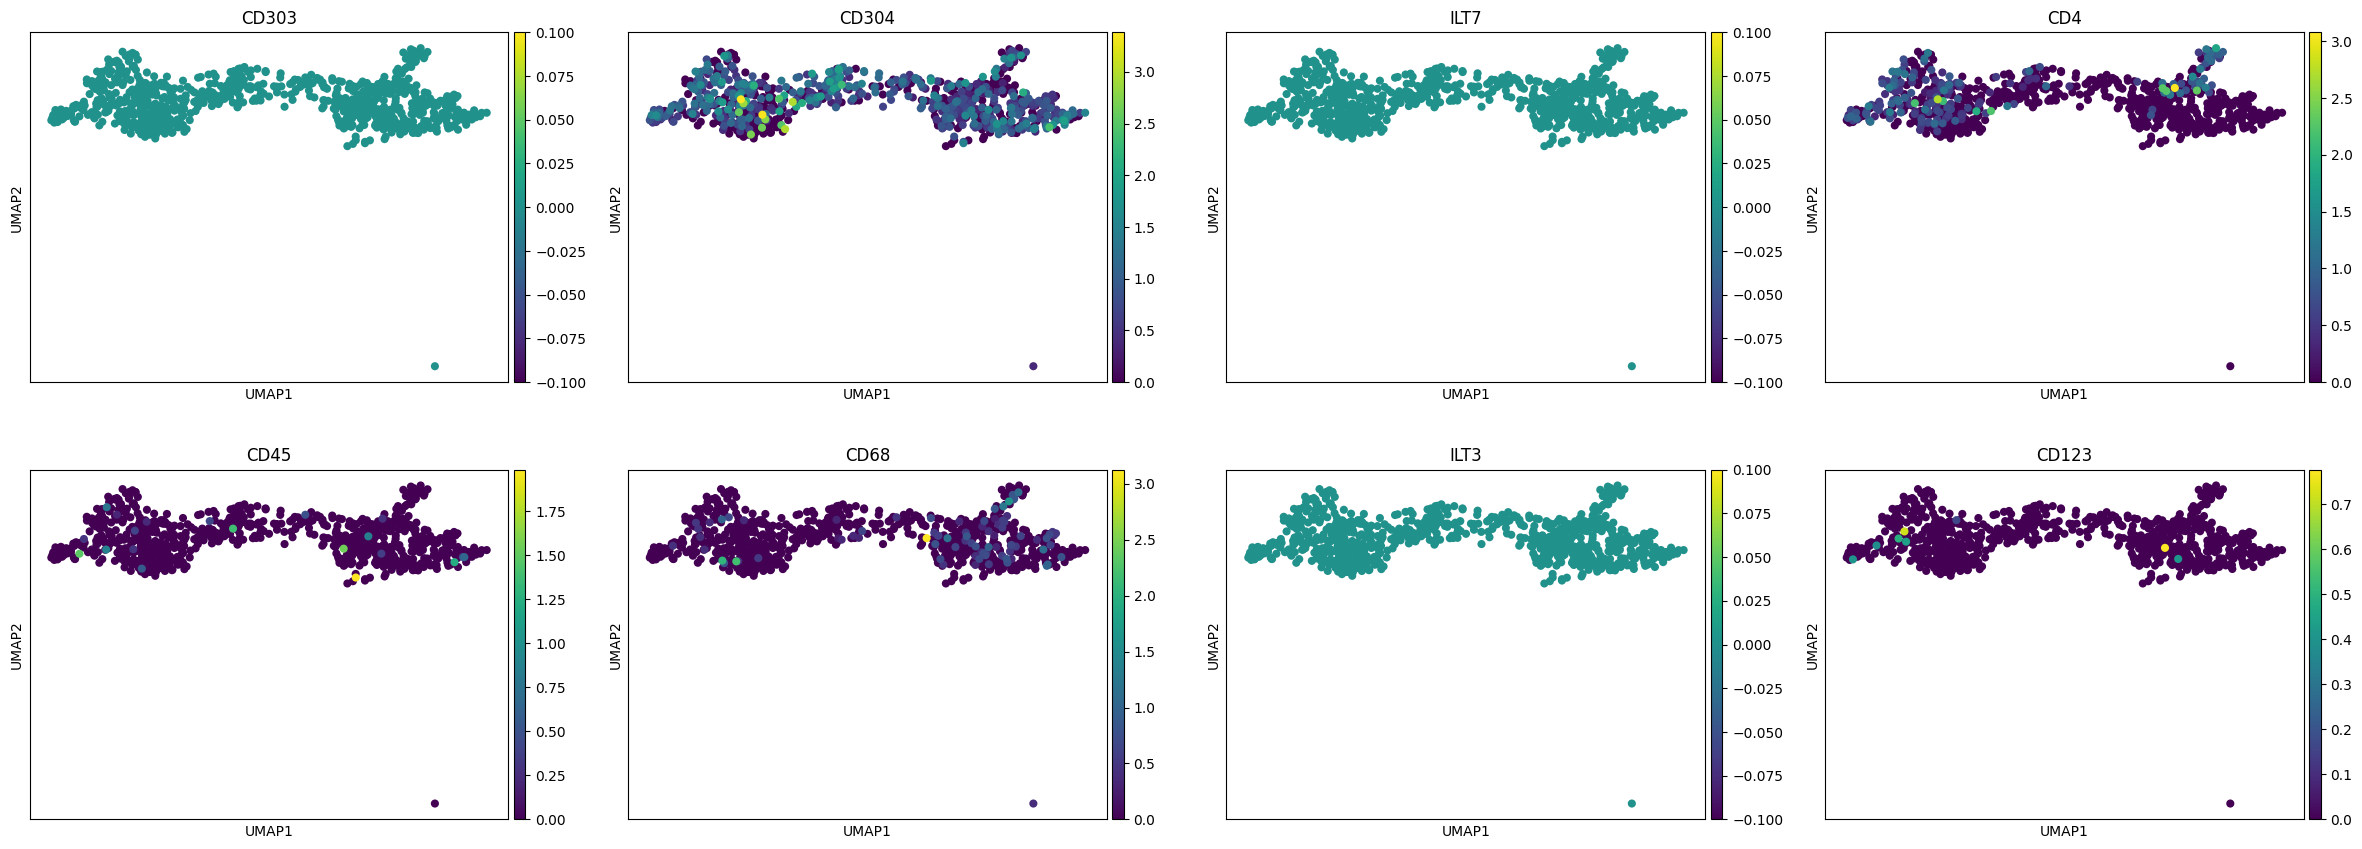

In [16]:
# Not expressed
sc.pl.umap(adata[adata.obs["cell_type"] == "Plasmacytoid dendritic cells"], 
           color= ["CD3G", "CD19", "CD14", "FCGR3A", "ITGAX"],
           title=["CD3", "CD19", "CD14", "CD16", "CD11c"])
# Overexpressed
sc.pl.umap(adata[adata.obs["cell_type"] == "Plasmacytoid dendritic cells"], 
           color= ["CLEC4C", "NRP1", "LILRA4", "CD4", "PTPRC", "CD68", "LILRB4", "IL3RA"],
           title=["CD303", "CD304", "ILT7", "CD4", "CD45", "CD68", "ILT3", "CD123"])

As we can see, all the non expressed genes are in fact not expressed in this celltype but, of all the genes that we would expect to be present, we can only say that CD304 and CD4 (timidly) are there. This indicates that this cluster is probably not well llabelled by out automatic method. This could be because the method takes into consideration more genes than the ones mentioned bu Ye et al, and we can conclude that we have a discrepancy here. Another aspect about this celltype is that there are some cancer cells identified as well by Cancer finder, as we can see in previous UMAPS. Although these cancer cells are only a fraction of the total cell population, this would indicate that there are some cancerous behabiours in these clusters. 

As The best course here would be to relable this cluster as something else that can't be missinterpreted. In this case we will go with "Other".

#### Marker genes per cluster

Once we have annotated our data and we are confident with the output, we can extract marker genes for each cluster in order to have a better look at what is beeing expressed in each cluster. This information will be really important to use if we want to compare the differences in between the grups to perform 

In [17]:
sc.tl.rank_genes_groups(adata, groupby="leiden")
marker_genes = sc.get.rank_genes_groups_df(adata, None)
# marker_genes.to_excel("Results/Marker_genes_per_clust.xlsx")


In [19]:
mg_lst = [pd.DataFrame(marker_genes[(marker_genes["group"] == clust) & (marker_genes["pvals_adj"] <= 0.05)]).sort_values("logfoldchanges", ascending=False) for clust in adata.obs["leiden"].unique().tolist()]
names = [adata.obs[adata.obs["leiden"] == clust]["cell_type"][1][:26] + " C" + clust for clust in adata.obs["leiden"].unique().tolist()]
writer=pd.ExcelWriter(r"D:/Datos de usuario/Desktop/Single Cell Analysis/Gioblastoma (GSE214966)/Results/Marker_genes.xlsx")
for i, A in enumerate(mg_lst):
    A.to_excel(writer,sheet_name="{0}".format(names[i]))
writer.close()


C:\Users\Ferran\AppData\Local\Temp\ipykernel_8896\111016013.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  names = [adata.obs[adata.obs["leiden"] == clust]["cell_type"][1][:26] + " C" + clust for clust in adata.obs["leiden"].unique().tolist()]


## Gioblastoma Markers

"Glioblastoma cells adopt a spectrum of malignant cellular
programs recapitulating neural differentiation, ranging from neural
progenitor-like GSCs to more mature astrocyte-like cellular
states. As a consequence, neural progenitor markers (for
example, Nestin) and astrocyte lineage markers (for example, S100B
and GFAP) are widely used to characterize patient tumors
with Nestin+ GSCs representing a treatment-resistant subpopulation
that sustains long-term tumor growth" (Lee et al., 2024)

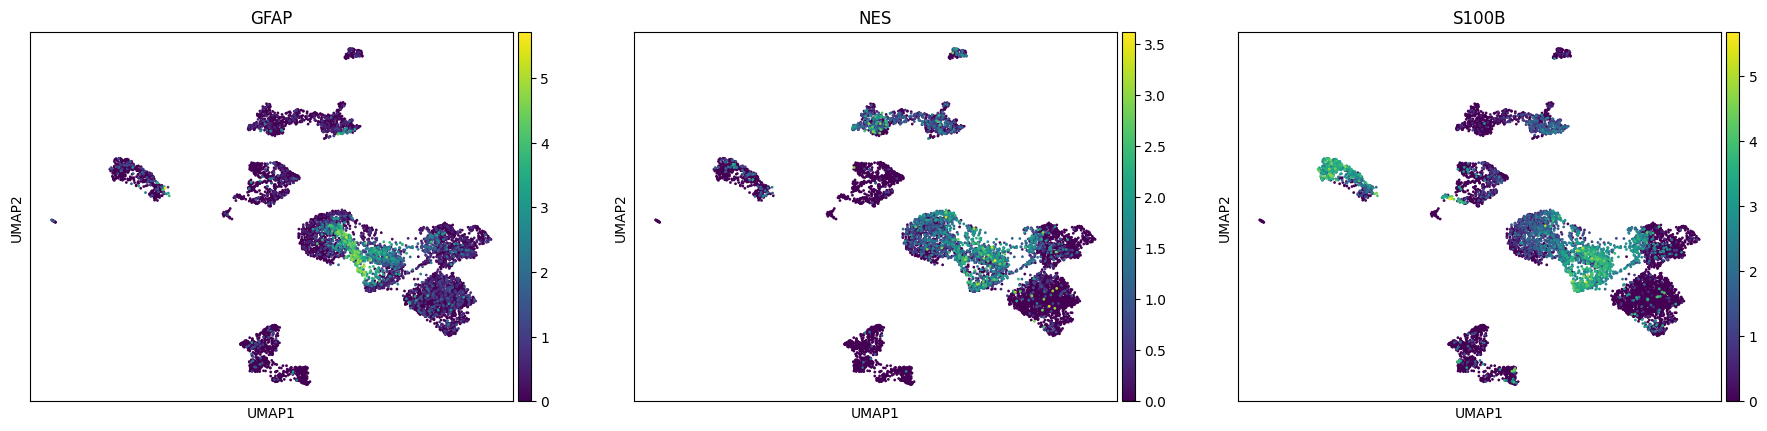

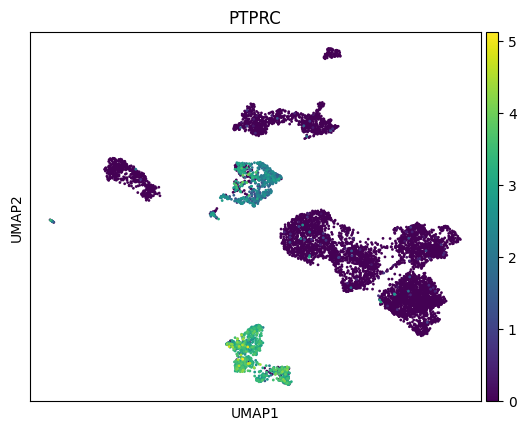

In [115]:
sc.pl.umap(adata, 
           color= ["GFAP", "NES", "S100B"], # GFAP, Nestin, S100B
           legend_loc="on data",
           legend_fontsize="medium",
           legend_fontweight="normal")

sc.pl.umap(adata, 
           color= ["PTPRC"], # CD45
           legend_loc="on data",
           legend_fontsize="medium",
           legend_fontweight="normal")

## Malignant Markers

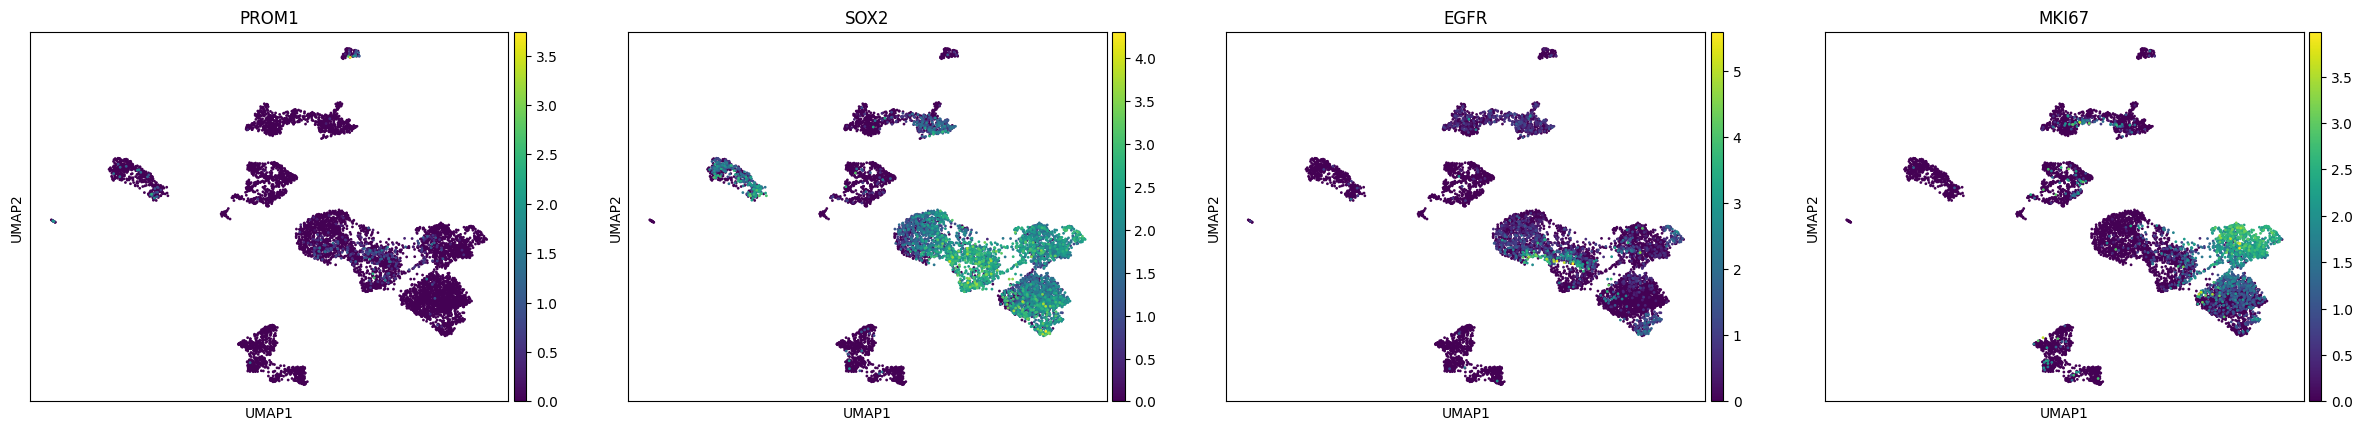